In [10]:
%matplotlib inline
from collections import deque, namedtuple
from PIL import Image
import itertools
import numpy as np
from matplotlib import pyplot as plt
import gym
import random

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Convolution2D, Permute
from keras.optimizers import RMSprop
from keras import backend as K



In [11]:

#set hyperparameters
MINI_BATCH_SIZE = 32
REPLAY_MEMORY_SIZE = 100000
AGENT_HISTORY_LENGTH = 4
TARGET_NETWORK_UPDATE_FREQUENCY = 100
DISCOUNT_FACTOR = 0.99
ACTION_REPEAT = 0
UPDATE_FREQUENCY = 4
LEARNING_RATE = 0.00025
GRADIENT_MOMENTUM = 0.95
SQUARED_GRADIENT_MOMENTUM = 0.95
MIN_SQUARED_GRADIENT = 0.01
INITIAL_EXPLORATION = 1
FINAL_EXPLORATION = 0.1
FINAL_EXPLORATION_FRAME = 1000
REPLAY_START_SIZE = 5000
NOOP_MAX = 30

GAME = "CartPole-v0"
NUM_EPISODES = 5000

In [12]:

#setup game env
env = gym.envs.make(GAME)
env.frameskip = ACTION_REPEAT
NUMBER_OF_ACTIONS = env.action_space.n
observation = env.reset()
#print(env.get_action_meanings())



[2017-02-10 19:46:52,346] Making new env: CartPole-v0


In [13]:

def cliped_mean_squared_error(y_true, y_pred):
    #return K.clip(K.mean(K.square(y_pred - y_true), axis=-1), -1, 1)
    return K.mean(K.square(y_pred - y_true), axis=-1)


In [14]:

def build_model():
    
    model = Sequential()
    input_shape = (AGENT_HISTORY_LENGTH*observation.shape[0])
    print input_shape
    model.add(Dense(256,input_dim=input_shape))
    model.add(Activation('relu'))
    model.add(Dense(NUMBER_OF_ACTIONS))
    model.add(Activation('linear'))
    model.compile(loss=cliped_mean_squared_error, optimizer=RMSprop())

    #SVG(model_to_dot(model).create(prog='dot', format='svg'))
    return model



In [15]:

# Initialize everything
episode_rewards = np.zeros(NUM_EPISODES)
episode_lengths = np.zeros(NUM_EPISODES)
loss = np.zeros(NUM_EPISODES)
total_frame = 0
all_frame = 0


# replay memory
replay_memory =  deque(maxlen = REPLAY_MEMORY_SIZE);
Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])

# state history
state_history = deque(maxlen = AGENT_HISTORY_LENGTH);

# The epsilon decay schedule
epsilons = np.linspace(INITIAL_EXPLORATION, FINAL_EXPLORATION, FINAL_EXPLORATION_FRAME)

# build model
train_model = build_model()
target_model = build_model()

max_reward = 0
max_ep = 0


16
16


Done Episode:0  reward:0  random_action:19  predict_action:0
Done Episode:1  reward:0  random_action:15  predict_action:0
Done Episode:2  reward:0  random_action:15  predict_action:0
Done Episode:3  reward:0  random_action:17  predict_action:0
Done Episode:4  reward:0  random_action:15  predict_action:0
Done Episode:5  reward:0  random_action:13  predict_action:0
Done Episode:6  reward:0  random_action:15  predict_action:0
Done Episode:7  reward:0  random_action:12  predict_action:0
Done Episode:8  reward:0  random_action:23  predict_action:0
Done Episode:9  reward:0  random_action:15  predict_action:0
Done Episode:10  reward:0  random_action:20  predict_action:0
Done Episode:11  reward:0  random_action:39  predict_action:0
Done Episode:12  reward:0  random_action:10  predict_action:0
Done Episode:13  reward:0  random_action:20  predict_action:0
Done Episode:14  reward:0  random_action:17  predict_action:0
Done Episode:15  reward:0  random_action:44  predict_action:0
Done Episode:16  r

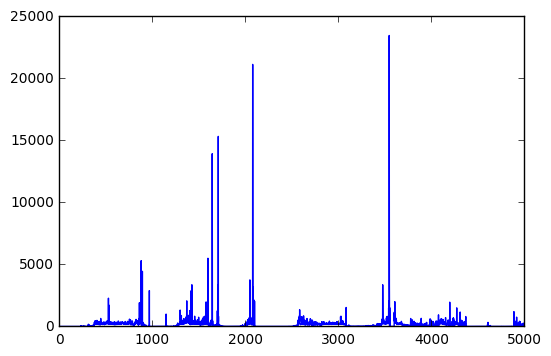

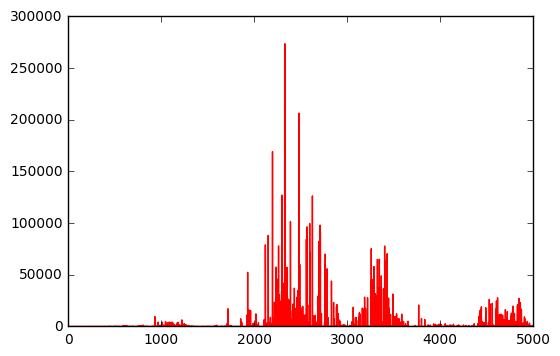

In [16]:
for i_episode in xrange(NUM_EPISODES):

    state = env.reset()
    # init state
    state = np.array(state)
    for _ in xrange(AGENT_HISTORY_LENGTH):
        state_history.append(state)
    state = np.array(state_history)
    state = state.flatten()
    
    count_ran = 0
    count_q = 0
 
    
    for t in itertools.count():
        # step random action
        if np.random.random() < epsilons[min(total_frame,FINAL_EXPLORATION_FRAME-1)]:
                count_ran += 1
                action = np.random.randint(NUMBER_OF_ACTIONS)
        
        else:
                count_q += 1
                q_values = train_model.predict(np.array([state]))[0]
                action = np.argmax(q_values)
                #print action,

        next_state, reward, done, info = env.step(action)

        #print 'process frame:{4} reward:{0}, done:{1}, info:{2}, action:{3}'.format(reward, done, info, action, t)
    
        if done == True :
            reward = -10

        # clip reward [-1,1]
        reward = max(-5, min(1, reward))
        # append next state

        next_state = np.array(next_state)
        state_history.append(next_state)
        next_state = np.array(state_history)
        next_state = next_state.flatten()
        # Save transition to replay memory
        replay_memory.append(Transition(state, action, reward, next_state, done))   
        
        # Update statistics
        
        all_frame += 1
        if all_frame>REPLAY_START_SIZE :
            total_frame += 1
            episode_rewards[i_episode] += reward
            episode_lengths[i_episode] = t
        
        # train network    
        if total_frame % UPDATE_FREQUENCY == 0 and total_frame != 0 :
            # Sample a minibatch from the replay memory
            samples = random.sample(replay_memory, MINI_BATCH_SIZE)
            states_batch, action_batch, reward_batch, next_states_batch, done_batch = map(np.array, zip(*samples))

            # Calculate q values and targets
            q_values = train_model.predict(states_batch)
            q_values_next = target_model.predict(next_states_batch)
            new_q_values_batch = reward_batch + np.invert(done_batch).astype(np.float32) * DISCOUNT_FACTOR * np.amax(q_values_next, axis=1)
            for b in xrange(MINI_BATCH_SIZE) :
                q_values[b][action_batch[b]] = new_q_values_batch[b]
            targets_batch = q_values

            # Perform gradient descent update
            #print 'train'
            states_batch = np.array(states_batch)
            loss[i_episode] = train_model.train_on_batch(states_batch, targets_batch)
        
        # check if terminated
        if done:
            break
        else:
            state = next_state
                
        # update target network    
        if total_frame != 0 and total_frame % TARGET_NETWORK_UPDATE_FREQUENCY == 0:
            #print "update"
            target_model.set_weights(train_model.get_weights())
            # save model
            #print 'save model'
            save_name = 'dqn_carpole_{0}.h5'.format(total_frame)
            #train_model.save(save_name)
    if max_reward < episode_rewards[i_episode] :
        max_reward = episode_rewards[i_episode]
        max_ep = i_episode
    #print ''
    print 'Done Episode:%i  reward:%i  random_action:%i  predict_action:%i' % (i_episode,episode_rewards[i_episode],count_ran, count_q)
save_name = 'dqn_carpole_final_{0}.h5'.format(NUM_EPISODES)
train_model.save(save_name)
print max_ep
print max_reward
plt.plot(episode_rewards, lw=1)
plt.show()
plt.plot(loss, lw=1, c='r')
plt.show()